# TP2: Techniques de graphes.

Boisvenue, Étienne (1798942)

Pigeon, Élisa (1970583)


LOG6308: Systèmes de recommandations

Samedi 2 novembre, A2019.

**Mise en contexte:**

Le travail gravite autour de la recommandations d'articles scientifiques. En premier lieu, on nous demande de recommander des articles scientifiques en utilisant le graphe dirigé dont chaque sommet est un article et chaque arête est une citation. Ceci demande d'appliquer l'algorithme Page Rank.

On compare par la suite nos résultats avec une approche item-item, en s'assurant de valider les performances de l'approche avec une validation croisée. La détermination des similarités entre les articles est laissé à notre discrétion. 



**Données:**

Une liste de 1090 références nous est fournie, extraite de la base de données Citeseer. Seules les citations contenus à l'intérieur de ces 1090 références font parties de notre base de données (matrice d'adjacence). Ainsi, lorsque il est possible que l'article référence en réalité à beaucoup plus d'articles que ce que nous observons dans note matrice d'adjacence. 


**Terminologie:**

- *Référence*: Une référence d'un article représente un lien sortant de l'article. Cela veut donc dire que la référence est citée dans l'article.

- *Référant*: Un référant d'un article représente un lien entrant de l'article. Cela veut donc dire que le référant mentionne l'article. 

## Importation des modules pertinents

In [1]:
# Retrait de l'affichage des avertissements
options(warn=-1)

# Téléchargement
#install.packages("igraph")
#install.packages("network")
#install.packages("sna")
#install.packages("GGally")
#install.packages("lsa")
#install.packages("philentropy")
#install.packages("hash")


# Importation
library(igraph)
library(network)
library(sna)
library(ggplot2)
library(GGally)
library(data.table)
library(tidyverse)
library(Matrix)
library(lsa)
library(hash)
library(philentropy) ###### https://cran.r-project.org/web/packages/philentropy/vignettes/Distances.html



Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

network: Classes for Relational Data
Version 1.15 created on 2019-04-01.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: 'network'

The following objects are masked from 'package:igraph':

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.

## Fonctions utiles

In [2]:
# Calcul la valeur modale d'un vecteur. Tiré de: https://www.tutorialspoint.com/r/r_mean_median_mode.htm
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

# Retourne la similitude en cosinus entre un vecteur v et une matrice m
cosinus.vm <- function(v,m) { n <- sqrt(colSums(m^2)); (v %*% m)/(n * sqrt(sum(v^2))) }


# Retourne les positions (index) des n valeur maximales dans la matrice m
max.nindex <- function(m, n=5) {
    i <- order(m, decreasing=TRUE)
    return(i[1:n])
}

# Retourne les positions (index) des n valeurs minimales dans la matrice m
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}

## Importation des données
*m* est la matrice d'adjacence décrivant complètement note graphe. Voici comment lire les données dans *m*: S'il y a la valeur 1 sur la ligne représentant la référence *A* à l'intersection de la colonne représentant la référence *B*, alors *A* cite *B*.
Les lignes représentent donc les articles cités alors que les colonnes représentent les articles étant cités. 

In [3]:
m = read.table("http://cours.polymtl.ca/MDesmarais/log6308/Public/citeseer.rtable")

## Brève exploration des données (statistiques descriptives)
Exploration initiale de l'ensemble de données. Le but est simplement de se familiariser avec l'ensemble de données pour mieux le comprendre et être capable de trouver la valeur que l'on pourrait en retirer.

Explorons les différents attributs, la distribution des attributs et essayons d'avoir quelques *insights* initiaux. 

[1] "Nombre de lignes: 1090"

[1] "Nombre de colonnes: 1090"

[1] "La matrice d'adjacence est remplie à  0.242572174059423 %"

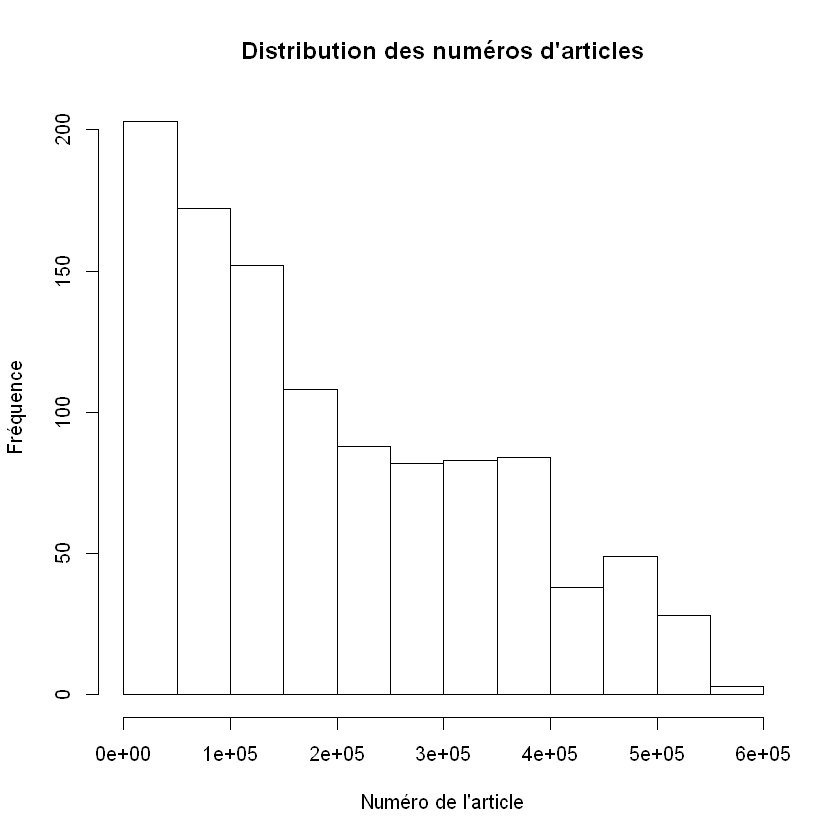

[1] "Nombre de références sortantes d'un article "

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   2.644   4.000  41.000 

[1] "Nombre de références entrantes d'un article "

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   2.644   3.000 170.000 

[1] "Valeur modale du nombre d'arcs entrant dans un article"

[1] 0

[1] "Valeur modale du nombre d'arcs sortant dans un article"

[1] 0

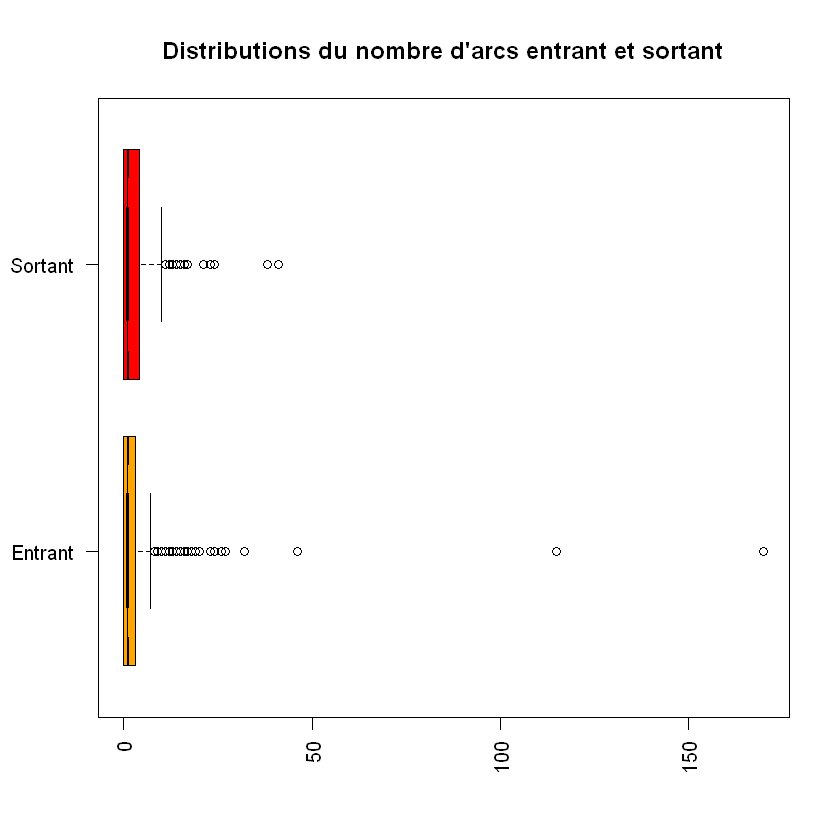

In [4]:
# On observe la dimension de la matrice d'adjacence
nb_ligne <- dim(m)[1]
nb_colonne <- dim(m)[2]
paste("Nombre de lignes:",nb_ligne)
paste("Nombre de colonnes:", nb_colonne)

# On observe le format des index (''nom des articles'')
articles <- row.names(m)
hist(as.numeric(articles),
    main="Distribution des numéros d'articles",
    xlab="Numéro de l'article",
    ylab="Fréquence")

# On calcul le pourcentage de remplissage de la matrice d'adjacence
nb_case <- nb_ligne*nb_colonne
non_nul <- sum(m[m!=0])
pourcent_rempli <- non_nul/nb_case
paste("La matrice d'adjacence est remplie à ", pourcent_rempli*100, "%")

# Nombre de liens sortant (références) par article
ref_in <- colSums(m)

# Nombre de liens entrant (référençant) par article
ref_out <- rowSums(m)


# Distributions des arcs entrants et sortants de chaque article
# diagramme de Tukey
boxplot(ref_in, ref_out,
main = "Distributions du nombre d'arcs entrant et sortant",
at = c(1,2),
names = c("Entrant", "Sortant"),
las = 2,
col = c("orange","red"),
border = "black",
horizontal = TRUE,
notch = TRUE
)
# Résumé
paste("Nombre de références sortantes d'un article ")
summary(ref_out)
paste("Nombre de références entrantes d'un article ")
summary(ref_in)

# Valeurs modales
paste("Valeur modale du nombre d'arcs entrant dans un article")
(getmode(ref_in))
paste("Valeur modale du nombre d'arcs sortant dans un article")
(getmode(ref_out))

*m* est évidemment carré, puisque chaque article qui référence peut également être référencé. On observe également que les numéros des articles ne sont pas uniformément distribués (tel qu'il est souvent le cas dans une base de données pour les identifiants uniques). Malgré que la valeur des numéros d'articles n'est pas porteur d'information, il est important d'être conscient que les numéros d'articles ne sont pas nécessairement consécutif, comme il était le cas dans le TP1. Il faudra donc faire attention, car par exemple, l'article à la ligne (index) 56 dans la matrice d'adjacence ne représente pas nécessairement l'article numéro 56. 

La matrice d'adjacence est très creuse. Elle ne possède que 2882 éléments non-nuls, ce qui représente 0.24% de *m*. 

Selon les diagrammes de Tukey, nous observons que les positions des quartiles (reflétant la distribution) sont similaires pour le nombre de références et de référencemment par article. La majorité des observations, pour les deux distributions, se trouvent entre 0 et 10. Les valeurs aberrantes (outliers) pour les arcs entrant s'étalent très loin, soit jusqu'à 170, alors que le maximum d'arcs sortant d'un article est de 41. Évidemment, la moyenne des deux distributions est la même, puisque nous travaillons avec un emsemble fermé (il n'exsite aucune référence entrante ou sortante qui ne fait pas partie de nos 1090 articles). Donc, en moyenne un article est référencé 2.66 fois et en moyenne il référence à 2.66 articles. 


La valeur modale pour le nombre d'arc entrant et le nombre d'arcs sortant d'un article sont tous deux de zéro. Ceci concorde avec le remplissage très faible de la matrice d'adjacence (seulement 0.24%).

[1] "Nombre d'article référant à soit-même"

[1] 61

[1] "Nombre d'articles possédant aucune références:  351"

[1] "Ceci représente  32.2018348623853 % de la base de données"

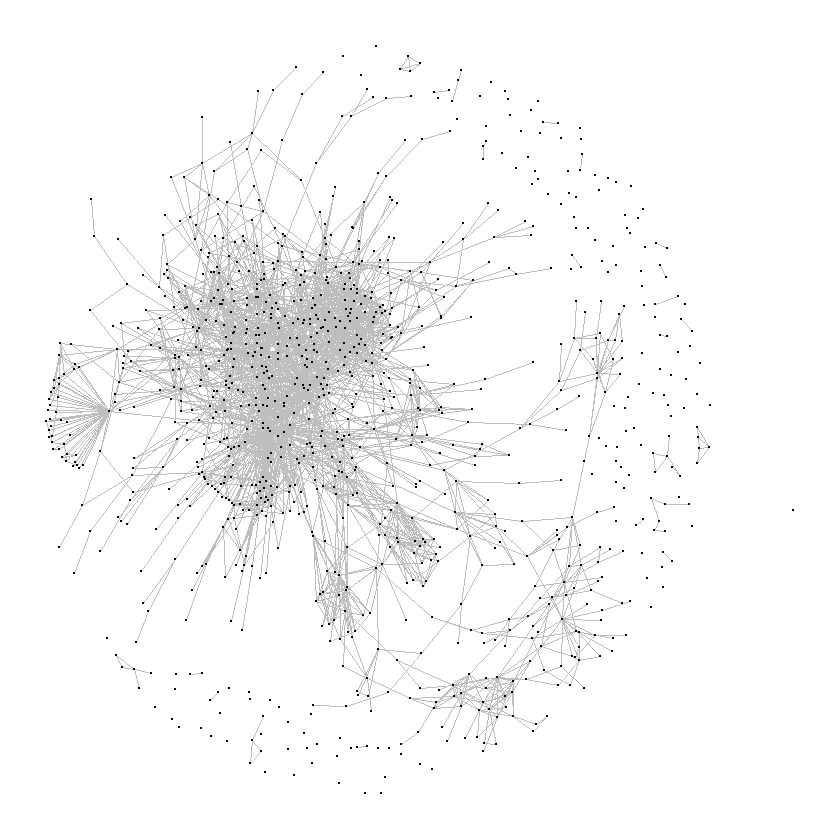

In [6]:
# Visualisation des référencements
ggnet2(m, node.size = 0.1, node.color = "black", edge.size = 0.01, edge.color = "grey")

# Nombre d'article référant à eux-même (éléments diagnonaux non-nul dans la matrice d'adjacence)
paste("Nombre d'article référant à soit-même")
sum(diag(as.matrix(m)))

# Nombre d'articles possédant zéro références
nb_aucune_ref <- sum(ref_out==0)
paste("Nombre d'articles possédant aucune références: ", nb_aucune_ref)
paste("Ceci représente ", 100*nb_aucune_ref/nb_ligne, "% de la base de données")

In [7]:
# Validation que la matrice m ne possède que des 0 et des 1
unique(unlist(m))

[1] 0 1

61 articles référent à eux-même dans notre base de données, ce qui semble assez étrange...

351 articles ne possèdent aucunes références, ce qui fort probablement un artefact issue de la méthode de collection des articles. Cependant, cela démontre malgré tout de la qualité moindre de la base de données fournies (i.e. beaucoup d'information sont difficilement interprétable). 

Le figure ci-dessus est une représentation parmis d'autres du graphe décrit par notre matrice d'adjacence. On observe tout d'abord que le graphe n'est pas connexe. Ainsi, il n'existe pas un chemin de chaque article vers chacun des autres. Il est donc également impossible de créer de cycles eulériens ou hamiltoniens dans ce graphe.

Il existe également plusieurs petites cliques isolées de trois ou quatres articles. Cela démontre que ces articles ce références tous entre-eux, donc potentiellement qu'ils sont *équivalent*, dans le sens qu'ils fournissent probablement le même type d'information au lecteur. Cependant, chronologiquemment, il est étrange d'avoir des cycles dans le graphe. 

Au centre du graphe ce trouve un grands nombres d'articles fortemment connectés. Il es fort probable que ceci soit un artefact issu de la méthodologie de collecte de données. Selon ce graphe, il semblerait que la personne ayant collectée les données soit partie d'un article et a ajouté graduellement tous les articles référencés par celui-ci et ainsi de suite (récursivement). De ce fait, lorsque l'on arrête la récursion, il est normale que les articles ajoutés à la fin contiennent peu d'arêtes. Il est fort probable que toutes les références des articles ajoutés en premier se retrouvent dans ce graphe alors que très peu de références des articles ajoutés en dernier ne se retrouvent dans ce graphe. 

## Réponses aux questions

### Question 1: Appliquez l'algorithme Page Rank pour déterminer les autres lectures recommandées et une variante.
Nous appliquons donc l'algorithme de PageRank sur l'ensemble de notre graphe, soit la matrice *m* d'adjacence de taille 1090 par 1090. Par la suite, nous allons extraire les valeur des Page Rank pour les premiers voisins de l'article mentionné (soit 422908). Nous définisson en premier lieu les voisins comme étant les articles référencés par l'article *422908*. 

On suggère donc comme prochaine lecture à un utilisateur lisant l'article *422908*, l'article référencés par *422908* qui est le *plus populaire*.


Voici le titre et une courte description de l'article *422908*:

- **Titre**: Symbolic Model Checking for Real-time Systems
- **Description**: We describe finite-state programs over real-numbered time in a guardedcommandlanguage with real-valued clocks or, equivalently, as finite automata withreal-valued clocks. Model checking answers the question which states of a real-timeprogram satisfy a branching-time specification (given in an extension of CTL with clockvariables). We develop an algorithm that computes this set of states symbolically as afixpoint of a functional on state predicates, without constructing the state space.For this purpose, we introduce a -calculus on computation trees over real-numberedtime. Unfortunately, many standard program properties, such as response for allnonzeno execution sequences (during which time diverges), cannot be characterizedby fixpoints: we show that the expressiveness of the timed -calculus is incomparableto the expressiveness of timed CTL. Fortunately, this result does not impair thesymbolic verification of "implementable" real-time programs---those whose safety...




Cette description va nous permettre de savoir si les articles que nous suggérons semblent adéquat (évaluation très subjective, mais mieux que de simplement avoir une confiance aveugle en l'algorithme PageRank). 

In [5]:
# Nombre d'arcs sortant de 422908 (articles référés par 422908)
paste("Nombre d'articles sortant de 422908:",ref_out['422908'])

# Noms des articles sortant de 422908
paste("Noms des articles sortant de 422908:")
articles[which(m['422908',]==1)]

# Nombre d'arcs entrant dans 422908 (articles référant à 422908)
cat("\n")
paste("Nombre d'arcticles entrant dans 422908:",ref_in['X422908'])
# Noms des articles entrant de 422908
paste("Noms des articles entrant de 422908:")
articles[which(m[,'X422908']==1)]

[1] "Nombre d'articles sortant de 422908: 17"

[1] "Noms des articles sortant de 422908:"

[1] "110303" "124"    "131548" "147460" "149673" "155792" "17094"  "19422" 
 [9] "241538" "311874" "315693" "3170"   "396568" "466838" "497542" "522428"
[17] "64835"

[1] "Nombre d'arcticles entrant dans 422908: 46"

[1] "Noms des articles entrant de 422908:"

[1] "10302"  "106034" "120172" "124"    "125089" "131548" "136975" "139134"
 [9] "147460" "156791" "167226" "17507"  "177173" "181463" "182742" "226359"
[17] "26170"  "28323"  "289188" "297641" "304747" "3170"   "3175"   "322240"
[25] "34792"  "366858" "392298" "3950"   "395364" "464834" "468667" "496938"
[33] "497542" "64835"  "6497"   "66285"  "66291"  "7099"   "7624"   "78418" 
[41] "79188"  "83263"  "83509"  "83730"  "96767"  "98185"

Il y a donc 17 arcs sortant de 422908 et 46 liens entrant dans 422908.

Appliquons Page Rank en initialisant la valeur de chaque article à 1. On initialise le facteur d'amortissement à 0.85 et on ne considère comme premier voisin que les arcs sortant de 422908.

À chaque itération, nous conservons les valeurs des PageRank. Ainsi, nous allons pouvoir observer la convergence de l'ordonnacement des articles et également observer la convergence de la somme des PageRank. Puisque nous divisons par le nombre de sommets contenus dans le graphe (soit 1090), la somme des Page Rank devraient converger vers 1. Par contre, pour éviter de diviser par zéro, nous ajoutons plus 1 au dénominateur (représentant le nombre de liens sortant) dans l'algorithme de PageRank. Ainsi, la somme ne convergera pas vers 1, mais vers un nombre un peu plus petit que un (dans notre cas, environ 0.25). 

In [5]:
# Initialisation
remove(pr)
pr <- rep(1,nb_ligne)
d <- 0.85
nb_iteration <- 50
iteration <-seq(nb_iteration)
pr_matrice <- matrix( rep( 0, len=nb_ligne*nb_iteration), nrow = nb_iteration)


# Itérations de l'algorithme PageRank
for (i in iteration){
    pr <- (1-d)/nb_ligne + (d * (t(m) %*% (pr/(rowSums(m)+1))))
    pr_matrice[i,]<-pr
}
paste("Quartiles des PageRank: ")
summary(pr)

[1] "Quartiles des PageRank: "

       V1           
 Min.   :0.0001376  
 1st Qu.:0.0001376  
 Median :0.0001616  
 Mean   :0.0002309  
 3rd Qu.:0.0002252  
 Max.   :0.0073901  

Assurons-nous d'avoir atteint la convergence de l'algorithme en explorant la matrice *pr_matrice* qui contient les résultats de chacune des itérations. Pour savoir si nous avons fait assez d'itérations, nous devons avoir converger vers un ordonnancement des pages (*Page Ranking*). De plus, à convergence, la somme du vecteur de PageRank devrait se stabiliser. 

Puisque le minimum des PageRank est égal à la valeur du premier quartile, nous pouvons en déduire que le premier quart des valeurs de PageRank sont toutes de 0.0001376. 

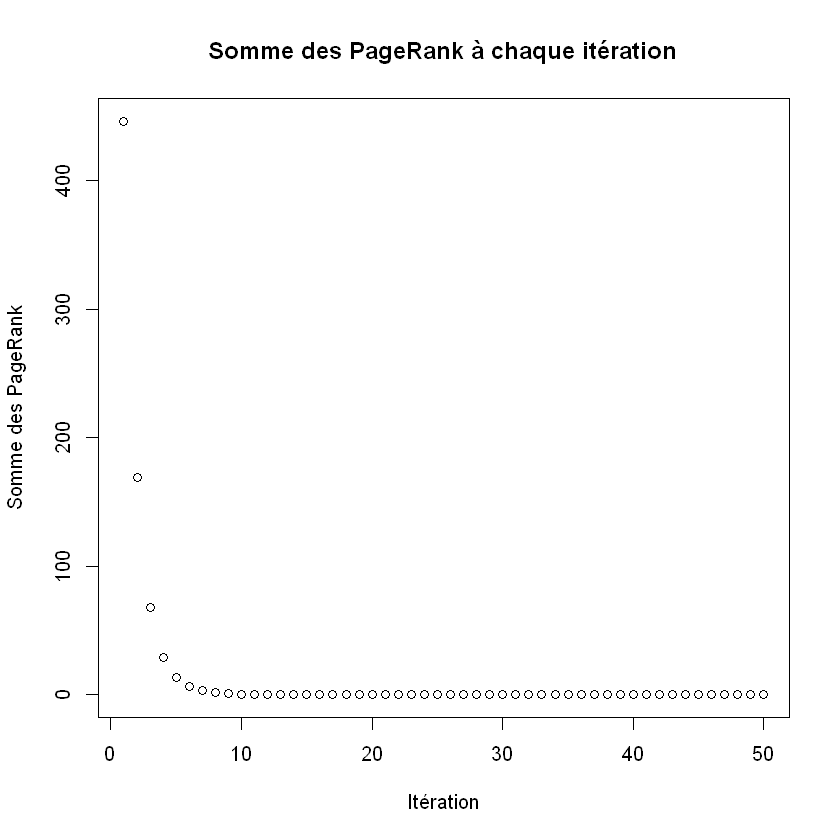

In [7]:
somme_pr <- rowSums(pr_matrice)
plot(iteration, somme_pr,
    main="Somme des PageRank à chaque itération",
    xlab="Itération",
    ylab="Somme des PageRank")

In [8]:
# On regarde si pour les dernières itérations, l'ordonnancement a convergé
# On présente ici les index des articles (donc entre 1 et 1090)
# Ceci est l'ordonnancement des 1090 articles (pas seulement les voisins de 422908)
for (i in iteration){
print(max.nindex(pr_matrice[i,],15))
    }

 [1] 547 295 408 916 747 494 675 232 766 344 720 415 749 998 551
 [1] 547 295 363 312 945 232 494 747 985 916 889 415 184 954 961
 [1] 547 295 232 312 985 363 411 494 184 945 961 747 889 954 557
 [1] 547 985 232 295 312 184 961 363 557 411 889 723 747 432 494
 [1] 985 232 547 184 961 295 557 312 723 854 889 432  41 169 747
 [1] 985 232 184 961 547 557 723 854 295  41 169 889 312 747 432
 [1] 985 232 184 961 557 723  41 169 547 854 889 295 747 710 168
 [1] 985 232 184 961 557 723  41 169 889 747 710 547 854 168 758
 [1]  985  232  184  961  557  723   41  169  889  710  747  168  547  758 1081
 [1]  985  232  184  961  557  723   41  169  889  747  710  168  547  758 1081
 [1] 232 985 184 961 557 723  41 169 889 547 747 710 168 295 758
 [1] 232 985 184 961 557 723 547  41 169 889 747 295 710 168 758
 [1] 232 985 184 961 547 557 723 295  41 169 889 747 710 168 758
 [1]  232  985  547  184  961  295  557  723   41  747  169  889  710  168 1081
 [1] 547 232 985 295 184 961 557 723 747  41 

Nous semblons donc avoir convergé dès l'itération 20 environ. On remarque également que beaucoup des 17 articles référés par l'article *422908* se retrouve dans les top PageRank (lorsque l'on regarde l'entièreté des 1090 valeurs de PageRank).

In [6]:
# On extrait les valeurs des PageRank des articles que 422908 réfère
index_voisin1_out<-which((m['422908',]==1)==TRUE)
pr_voisin1_out <- pr[index_voisin1_out]
articles_voisin1_out <- articles[index_voisin1_out]

# On stock le tout dans un dataframe et on tri en ordre décroissant selon la PageRank
df_voisin1_out <- data.frame(index_voisin1_out,articles_voisin1_out, pr_voisin1_out)
df_voisin1_out <- df_voisin1_out[with(df_voisin1_out, order(pr_voisin1_out, decreasing=TRUE)),]
cat("\n")
paste("Références de 422908 classées en ordre de recommendation (les plus pertinentes étant en premier)")
head(df_voisin1_out)
paste("Quartiles des PageRank des voisins sortant de 422908")
(summary(df_voisin1_out[,"pr_voisin1_out"]))

[1] "Références de 422908 classées en ordre de recommendation (les plus pertinentes étant en premier)"

,index_voisin1_out,articles_voisin1_out,pr_voisin1_out
10,547,311874,0.007390081
8,295,19422,0.004107933
7,232,17094,0.001943729
6,184,155792,0.001227710
17,961,64835,0.001172779
16,889,522428,0.001104272


[1] "Quartiles des PageRank des voisins sortant de 422908"

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0002120 0.0004821 0.0008514 0.0013689 0.0011728 0.0073901 

**Clarification des noms de colonnes dans le dataframe présentant les résultats**: 

- La colonne *index_voisin1_out* contient la position (entre 1 et 1090) de l'article dans le vecteur *articles*.

- La colonne *articles_voisin1_out* contient la valeur de l'élément à la position *index_voisin1_out* dans le vecteur *articles*.

- La colonne *pr_voisin1_out* contient la valeur du PageRank de cet article.




Tous les articles de ce dataframe sont des articles qui sont référés par *422908* (d'où l'appelation *out*).

Donc, selon la méthodologie que nous venons de mettre de l'avant, nous pouvons suggérer à un utilisateur un article populaire présent dans la liste des références de l'article qu'il lit actuellement (soit l'article *422908*). Si nous avions 3 suggestions à lui faire, elles seraient les articles numéros *311874*, *19422* et *17094*. Voici les titres et descriptions de ces articles: 

- **311874**:
    - *Titre*:**Graph-Based Algorithms for Boolean Function Manipulation**
    - *Description*: In this paper we present a new data structure for representing Boolean functions and an associated set of manipulation algorithms. Functions are represented by directed, acyclic graphs in a manner similar to the representations introduced by Lee [1] and Akers [2], but with further restrictions on the ordering of decision variables in the graph. Although a function requires, in the worst case, a graph of size exponential in the number of arguments, many of the functions encountered in typical applications have a more reasonable representation. Our algorithms have time complexity proportional to the sizes of the graphs being operated on, and hence are quite efficient as long as the graphs do not grow too large. We present experimental results from applying these algorithms to problems in logic design verification that demonstrate the practicality of our approach. Index Terms: Boolean functions, symbolic manipulation, binary decision diagrams, logic design verification 1.
    
    

- **19422**:
    - *Titre*: **Symbolic Model Checking: 10 20 States and Beyond**
    - *Description*: Many different methods have been devised for automatically verifyingfinite state systems by examining state-graph models of systembehavior. These methods all depend on decision procedures that explicitlyrepresent the state space using a list or a table that grows inproportion to the number of states. We describe a general method thatrepresents the state space symbolically instead of explicitly. The generalityof our method comes from using a dialect of the Mu-Calculus asthe primary specification language. We describe a model checking algorithmfor Mu-Calculus formulas that uses Bryant's Binary DecisionDiagrams (1986) to represent relations and formulas. We then showhow our new Mu-Calculus model checking algorithm can be used to deriveefficient decision procedures for CTL model checking, satisfiabilityof linear-time temporal logic formulas, strong and weak observationalequivalence of finite transition systems, and language containment forfinite !-automata.
    
    
    
- **17094**:
    - *Titre*: **A Really Temporal Logic**
    - *Description*: We introduce a temporal logic for the specification of real-time systems.Our logic, TPTL, employs a novel quantifier construct for referencing time: the freezequantifier binds a variable to the time of the local temporal context. TPTL is both anatural language for specification and a suitable formalism for verification. We presenta tableau-based decision procedure and a model checking algorithm for TPTL. Severalgeneralizations of TPTL are shown to be highly undecidable.1 IntroductionLinear temporal logic is a widely accepted language for specifying properties of reactive systemsand their behavior over time [Pnu77, OL82, MP92]. The tableau-based satisfiability algorithmfor its propositional version, PTL, forms the basis for the automatic verification and synthesis offinite-state systems [LP84, MW84].PTL is interpreted over models that abstract away from the actual times at which eventsoccur, retaining only temporal ordering information about the states of a system.

Il est également intéressant d'inclure dans les articles à retenir pour la suggestion, les articles représentant des arcs entrant dans *422908*. Nous n'avons pas besoin de recalculer le PageRank de chaque page, mais simplement de changer notre filtre (au lieu de prendre seulement les articles dans la lignes de l'article *422908* comme suggestions possibles, nous incluant également les articles dont la valeur est non-nulle dans la colonne *422908* de la matrice d'adjacence). 

Nous étendons nos possibilités de 17 articles à 17+46=63 articles. Il est possible que les trois même suggestions d'article se retrouvent quand même avec les PageRank les plus élevé.

In [7]:
# On extrait les valeurs des PageRank des articles qui réfèrent à 422908
index_voisin1_in<-which((m[,'X422908']==1)==TRUE)
pr_voisin1_in <- pr[index_voisin1_in]
articles_voisin1_in <- articles[index_voisin1_in]

# On stock le tout dans un dataframe et on tri en ordre décroissant selon la PageRank
df_voisin1_in <- data.frame(index_voisin1_in,articles_voisin1_in, pr_voisin1_in)
df_voisin1_in <- df_voisin1_in[with(df_voisin1_in, order(pr_voisin1_in, decreasing=TRUE)),]
paste("Référant de 422908 classés en ordre de recommendation (les plus pertinents étant en premier)")
head(df_voisin1_in)
paste("Quartiles des PageRank des voisins entrant de 422908")
(summary(df_voisin1_in[,"pr_voisin1_in"]))

[1] "Référant de 422908 classés en ordre de recommendation (les plus pertinents étant en premier)"

,index_voisin1_in,articles_voisin1_in,pr_voisin1_in
34,961,64835,0.0011727795
45,1081,96767,0.0007059540
6,113,131548,0.0005526332
9,162,147460,0.0005513630
33,859,497542,0.0004937419
12,238,17507,0.0004829323


[1] "Quartiles des PageRank des voisins entrant de 422908"

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001376 0.0001540 0.0002048 0.0002835 0.0003530 0.0011728 

En moyenne, les premiers voisins sortant de l'article *422908* ont une valeur de PageRank de 0.0013689.
En moyenne, les premiers voisins entrant de l'article *422908* ont une valeur de PageRank de 0.0002835.

Les arcs sorant de *422908* semble donc être en moyenne plus populaires que les liens entrant de *422908*. 

Si nous avions à suggérer des articles à lire parmis ceux qui référence l'article *422908*, nous suggérons: 


- **64835**

- **96767**

- **131548**


**Il nous est impossible d'extraire les titres et les descriptions de cours puisque le lien vers la base de données ne fonctionne plus, dû à des mises à jours de sécurité sur les serveurs de Polytechnique Montréal. Nous aurions aimer extraire les titres et descriptions pour voir s'ils sont semblable à ceux de l'article 422908.**
    
    
Cependant, les valeurs des PageRank des arcs sortant de *422908* sont d'environ un ordre de grandeur de plus que les valeurs des PageRank des arcs entrant de *422908*. Nos 3 meilleures recommendations d'articles demeurent donc les recommendations d'articles sortant (pour ce qui est de l'article *422908*). 

Nous arrêtons donc l'exploration des arcs entrants. 


Allons maintenant chercher les articles étant des références de références de l'article *422908*. Pour ce faire, nous calculons la matrice d'adjacence au carrée. Cette matrice contient donc maintenant le nombre de chemin de longeur 2 reliant l'article *422908* avec tous les autres 1089 articles. Le fait qu'il existe 1,2,3,... chemins vers l'article ne nous intéresse pas. Nous voulons simplement s'il existe ou non un chemin de degré 2 reliant *422908* avec un autre article. 

In [8]:
# Calcul de la matrice d'adjacence au carré
m_2 <- data.frame(as.matrix(m) %*% as.matrix(m))
paste("Il existe parfois plusieurs chemins d'ordre 2 reliant des articles: ")
unique(unlist(m_2))

# Nombre de références de références 
ref_out_2 <- rowSums(m_2!=0)
paste("Quartiles du nombre de références de références")
summary(ref_out_2)
paste("Nombre de références de références pour l'article 422908: ")
ref_out_2["422908"]


# Nombre de référant de référant
cat("\n")
ref_in_2 <- colSums(m_2!=0)
paste("Quartiles du nombre de référant de référant")
summary(ref_in_2)
paste("Nombre de référant de référant pour l'article 422908: ")
ref_in_2["X422908"]




[1] "Il existe parfois plusieurs chemins d'ordre 2 reliant des articles: "

[1]  0  1  2  4  3  6  5  7 12  8 13  9 10

[1] "Quartiles du nombre de références de références"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   5.766   7.000  79.000 

[1] "Nombre de références de références pour l'article 422908: "

422908 
    25

[1] "Quartiles du nombre de référant de référant"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   5.766   4.750 283.000 

[1] "Nombre de référant de référant pour l'article 422908: "

X422908 
    103

En moyenne, il est donc possible d'atteindre 5.77 articles en suivant les références de références à partir d'un article, à comparer avec 2.64 en ne considérant que les références de premier ordre. 

L'article *422908* possède 25 références de références (arcs sortant) et 103 référant de référant (arcs entrant). Au premier ordre, on se rappel que nous avions respectivement 17 et 46 articles pour ces métriques. 

Regardons les valeurs des PageRank de ces nouveaux articles relié à *422908* par des chemins de deux arcs. 

In [9]:
# On extrait les valeurs des PageRank des références de références de 422908
index_voisin2_out<-which((m_2['422908',]!=0)==TRUE)
pr_voisin2_out <- pr[index_voisin2_out]
articles_voisin2_out <- articles[index_voisin2_out]

# On stock le tout dans un dataframe et on tri en ordre décroissant selon la PageRank
df_voisin2_out <- data.frame(index_voisin2_out,articles_voisin2_out, pr_voisin2_out)
df_voisin2_out <- df_voisin2_out[with(df_voisin2_out, order(pr_voisin2_out, decreasing=TRUE)),]
paste("Références de références de 422908 classées en ordre de recommendation (les plus pertinentes étant en premier)")
head(df_voisin2_out)
(summary(df_voisin2_out[,"pr_voisin2_out"]))

[1] "Références de références de 422908 classées en ordre de recommendation (les plus pertinentes étant en premier)"

,index_voisin2_out,articles_voisin2_out,pr_voisin2_out
12,547,311874,0.007390081
7,295,19422,0.004107933
6,232,17094,0.001943729
17,747,422908,0.001574930
24,985,70445,0.001530473
8,312,206738,0.001517271


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0003519 0.0004937 0.0008514 0.0012850 0.0015023 0.0073901 

On remarque donc plusieurs doublons entre les voisin de premier ordre et de deuxième ordre de l'article *422908*. Cela veut donc dire que ces articles font partie d'un cycle contenant *422908*. Il est donc intéressant de fusionner les deux dataframes en éliminant les articles répétés.

In [10]:
merged_out <- (rbindlist(list(df_voisin1_out,df_voisin2_out), fill=FALSE))
colnames(merged_out) <- c("Index","Article","PageRank")
merged_out <- merged_out[!duplicated(merged_out)]
merged_out <- merged_out[with(merged_out, order(PageRank, decreasing=TRUE)),]
paste("PageRank des voisins sortant d'ordre 1 et 2 de l'article 422908")
head(merged_out,10)
paste("Par exemple, il existe: ",m_2['422908','X70445'], "chemins d'ordre 2 de 422908 vers 70445" )



Column 1 ['index_voisin2_out'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names. use.names='check' (default from v1.12.2) emits this message and proceeds as if use.names=FALSE for  backwards compatibility. See news item 5 in v1.12.2 for options to control this message.


[1] "PageRank des voisins sortant d'ordre 1 et 2 de l'article 422908"

Index,Article,PageRank
547,311874,0.007390081
295,19422,0.004107933
232,17094,0.001943729
747,422908,0.001574930
985,70445,0.001530473
312,206738,0.001517271
363,225173,0.001502258
184,155792,0.001227710
961,64835,0.001172779
889,522428,0.001104272


[1] "Par exemple, il existe:  4 chemins d'ordre 2 de 422908 vers 70445"

Le PageRank moyen pour les références de l'article *422908* est de 0.0013689 alors que le PageRank moyen pour les références de références de l'article *422908* est de 0.001285. Ces moyennes sont donc comparables. 

Lorsque nous étendons notre domaine de recherche aux références de références, le top 3 des articles suggérés ne change pas. Cela veut donc dire que les 3 articles avec les valeurs de PageRank les plus élevés parmis les voisins sortant d'ordre 1 et 2 sont d'ordre 1. Cependant, **en quatrième position, nous obtenons l'article *422908* lui-même!** Cela veut donc dire que l'article *422908* référence un article qui lui référence vers *422908*. Nous avons donc détecté un cycle contenant l'article *422908*. Cela souligne bien le fait qu'il faut faire attention pour ne pas recommender à un utilisateur de lire comme article suivant l'article qu'il est actuellement en train de lire. Cela peut facilement se produire lorsque l'article en lecture possède un PageRank élevé et que l'on étend les suggestions aux voisins de deuxième ordre. Puisque 61 articles dans notre base de données réfèrent à eux-même, il serait possible d'avoir l'article en lecture dans les suggestions même si l'analyse est limité aux premiers voisins. 

En cinquième position, nous obtenons l'article *70445* qui est un deuxième voisin de *422908*. Il existe 4 chemins de longueur deux reliant l'article *422908* à l'article *70445*. Ce nombre élevé de chemins de deuxième ordre est intéressant. Cela démontre que les articles *422908* et *70445* sont reliés de plusieurs façons. Il serait intéressant d'explorer ces 4 différents chemins pour voir si les 4 chemins  représentent les mêmes sujets. 

### Question 2: Comparez les recommandations de Page Rank avec celles d'une approche basée sur la similarité des articles.

La mesure de similarité pour commencer sera simplement la similarité en cosinus de la rangé *422908* avec toutes les autres lignes du dataframe *m*. Ainsi, les attributs de l'espace vectoriel dans lequel ont calcul cette similitude est simplement le fait de référencer ou non vers un article. De ce fait, selon cette approche, les articles les plus similaires seront les articles qui références majoritairement vers les mêmes articles. 

Pour cette question du tp, il est pratique d'utiliser la librairies *philentropy*. Cette librairie contient 46 calculs optimisés de distances et de similarités. Initiallement, cette librairie a été développée pour comparer des densités de probabilités. Nous pouvons nous en servir pour calculer des similarités et des distances entre chacune des observations (articles) de notre base de données. 

In [11]:
# On calcul la similarité en cosinus de chaque article avec chacun des autres
cos_simil <- as.data.frame(distance(m, method = "cosine"))

Metric: 'cosine'; comparing: 1090 vectors.


In [12]:
# On renomme les lignes et colonnes
colnames(cos_simil) <- articles
rownames(cos_simil) <- articles

# On extrait la similitude de l'article 422908 avec chacun des autres articles
cos_simil_422908 <- cos_simil['422908',]

# On valide que l'article 422908 possède une similitude parfaite (1) avec lui-même
(cos_simil_422908['422908'])

# On extrait les 10 articles les plus similaires à 422908


,422908
422908,1


In [13]:
# Transpose pour faciliter la lecture visuelle
t_cos_simil_422908 <- t(cos_simil_422908)
colnames(t_cos_simil_422908) <- 'cosinus avec 422908'


# Extraction des index les plus élevé
index_top_cos <- max.nindex(t_cos_simil_422908,11)

# Extraction des numéros d'articles avec le cosinus le plus élevé
articles_top_cos <- articles[index_top_cos]
paste("Articles recommendés selon la similitude en cosinus")
(articles_top_cos)

# Valeurs des cosinus de ces tops articles
paste("Valeur des cosinus des top articles similaires")
cos_simil_422908[index_top_cos]

[1] "Articles recommendés selon la similitude en cosinus"

[1] "422908" "96767"  "70445"  "149673" "466838" "155792" "53632"  "497542"
 [9] "3175"   "17507"  "147460"

[1] "Valeur des cosinus des top articles similaires"

,422908,96767,70445,149673,466838,155792,53632,497542,3175,17507,147460
422908,1,0.5144958,0.4950738,0.4850713,0.4850713,0.4583492,0.4583492,0.4338609,0.4287465,0.420084,0.396059


[1] "Il y a  351  similitudes en cosinus de valeur NaN."

[1] "Il y a  467  similitudes en cosinus nulle."

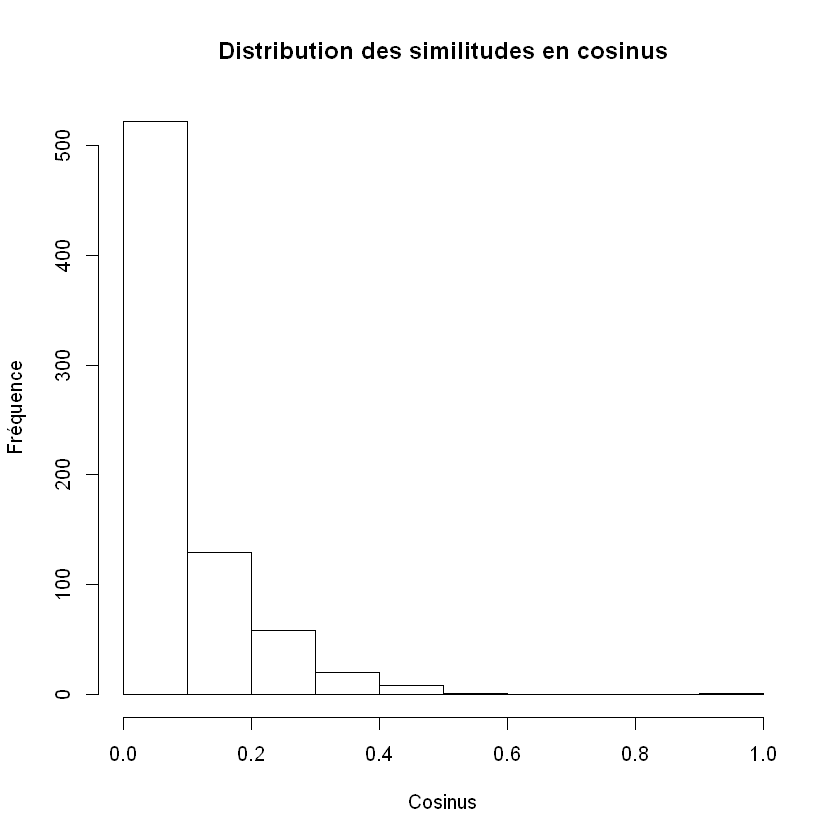

In [14]:
# On observe la distribution des similitudes en cosinus
# Il n'existe pas d'article avec une similitude supérieur à 0.52 (ce qui est relativement faible)
hist(as.numeric(cos_simil_422908),
    main="Distribution des similitudes en cosinus",
    xlab='Cosinus',
    ylab='Fréquence')

paste("Il y a ",length((cos_simil_422908[is.na(cos_simil_422908)]))," similitudes en cosinus de valeur NaN.")
paste("Il y a ",sum(!is.na(cos_simil_422908[cos_simil_422908==0]))," similitudes en cosinus nulle.")

En calculant la similarité en cosinus, nous obtenons beaucoup de zéro de de *NaN*. Il est facile de comprendre pourquoi si l'on étudie l'équivalence d'un cosinus en terme de produit scalaire:

\begin{equation}
cos(\theta)=\frac{v_1\cdot v_2}{|v_1||v_2|}
\end{equation}

Ainsi, lorsque les vecteurs $v_1$ et $v_2$ ne possèdent aucune références en commun (ce qui est très probable, puisque la base de donnée contient 1090 articles et la moyenne de références par article est de 2.6), alors le numérateur sera de zéro. Ceci résulte en une similarité en cosinus de zéro. 

Si soit $v_1$ ou $v_2$ fait partie des 351 articles n'ayant aucune référence, alors soit $|v_1|$ ou $|v_2|$ sera nul, ce qui impose une division par zéro dans le calcul du cosinus. Ainsi, nous obtenons une similarité en cosinus de *NaN*.

Nous avons réfléchi à retiré ces 351 articles qui ne possèdent aucune référence. Nous avons finalement décider de les conserver dans notre analyse pour mettre en valeur:
- L'importance d'accumuler des données de qualité.
- Les erreurs pouvant découler de données de moindre qualité.

Nous verons à la question 3 plusieurs erreurs découlant du fait que la grande majorité de nos articles possèdent très peu de références. 

In [15]:
# L'article 96767 est un lien entrant de premier ordre de l'article 422908.
m['96767','X422908']
which(m[,'X422908']==1)
which(articles=='96767')

[1] 1

[1]    9   26   75   92   97  113  126  135  162  185  216  238  246  256  260
[16]  368  448  487  496  518  531  560  561  566  624  668  716  721  722  806
[31]  811  858  859  961  962  968  970  989 1004 1010 1012 1029 1030 1032 1081
[46] 1087

[1] 1081

Évidemment, nous retrouvons que l'article 422908 possède une similitude en cosinus parfaite (de 1) avec lui-même. Ensuite, nous obtenons des similitudes entre 0.4 et 0.5 comme 10 articles les plus similaires. Objectivement, ces similitudes semblent très faible. Nous devons quand même garder en tête que nous sommes dans une matrice très creuse et de dimension 1090, ce qui pourraient expliquer ces faibles valeurs de similitudes. 


Les résultats d'articles similaire en cosinus à l'article *422908* sont très intéressant! Comme top 10 des articles les plus similaires en cosinus, nous obtenons le articles *96767*, *70445*, *149673*, *466838*, *155792*, *53632*, *497542*, *3175*, *17507*, *147460*. Parmis ceux-ci, *149673*, *466838*, *155792* *497542* et *14760* sont des références d'ordre 1 de l'article *422908*. Il y a donc 50% des articles les plus similaires en cosinus qui sont des voisins d'ordre 1. La similitude en cosinus semble donc relativement efficace pour trouver des voisins de premier ordre. Par contre, les recommendations selon la similitude en cosinus ne sont pas du tout les voisins qui avaient les PageRank les plus élevés. En effet, ils étaient respectivement en position 15, 16, 4, 12 et 11 sur les 17 voisins d'ordre 1. Si l'on compare avec les voisins d'ordre 1 et 2, nous observons que la 2e recommendation en cosinus (*70445*) est notre 4e recommendation en considérant les voisins d'ordre 2. Il devient donc intéressant de suggérer à l'utilisateur des articles qui sont à l'union de nos deux listes de recommendations, plutôt que de se fier uniquemment à une métrique (PageRank ou cosinus). On commence donc quelque peu à réfléchir selon des méthodes d'ensemble pour assurer le plus possibles que nos recommendations soient pertinentes. 

Mais qu'en est-il de l'article le plus similaire en cosinus avec *422908*, soit l'article *96767*? **C'est un arc entrant (référant) de *422908*!** C'est le référant de *422908* avec la seconde valeur de PageRank la plus élevée! Nous voyons donc l'importance de bien explorer notre jeu de données. Nous n'aurions jamais détecté cette relation si nous n'avions pas étendu notre analyse aux liens entrant de *422908* (en comparaison avec simplement considéré les voisins sortant de 1et et 2e ordre). 



Bref, la similitude en cosinus permet de suggérer quelques voisins de l'article, mais pas nécessairement les plus populaires (ceux avec le PageRank le plus élevé).



**Travail supplémentaire:**

Explorons une différente méthodologie pour détecter des similitudes entre les sommets d'un graphe. Lorsque tous les attributs d'observations sont binaires (comme ici dans la matrice d'adjacence de premier ordre), il est possible de calculer la **distance de Jaccard** entre deux observations (ici, chaque observation est un noeud de note graphe et chaque attribut binaire est l'existence ou non d'un arc vers chacun des autres articles). 

La distance de Jaccard entre deux sommets *A* et *B* est définie comme étant $1-J(A,B)$, où $J(A,B)$ est l'indice de Jaccard. L'indice de Jaccard est défini comme suit: 

\begin{equation}
J(A,B) = \frac{|A\cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A|+|B|-|A\cap B|}
\end{equation}.

Nous pouvons donc calculer $1-J(A,B)$ pour obtenir une distance qui réflète la proximité des articles, tout en conservant l'interprétation binaire des attributs. 

In [19]:
# Calcul de la distance de Jaccard de tous les articles entre-eux
jacc <- as.data.frame(distance(m, method = "jaccard"))
colnames(jacc) <- articles
rownames(jacc) <- articles

# On extrait les distances par rapport à 422908
jacc_422908 <- jacc['422908', ]

Metric: 'jaccard'; comparing: 1090 vectors.


[1] "Distance de 422908 avec lui-même: "

[1] 0

[1] "Articles les plus près selon la distance de Jaccard"

[1] "422908" "96767"  "70445"  "155792" "53632"  "17507"  "3175"   "149673"
 [9] "466838" "497542" "147460"

[1] "Valeur des distances de Jaccard des articles les plus près"

,422908,96767,70445,155792,53632,17507,3175,149673,466838,497542,147460
422908,0,0.6842105,0.7222222,0.7368421,0.7368421,0.7391304,0.75,0.7647059,0.7647059,0.7777778,0.7894737


,index_voisin1_out,articles_voisin1_out,pr_voisin1_out
10,547,311874,0.0073900807
8,295,19422,0.0041079335
7,232,17094,0.0019437288
6,184,155792,0.0012277102
17,961,64835,0.0011727795
16,889,522428,0.0011042722
11,557,315693,0.0009500090
13,723,396568,0.0009433561
1,41,110303,0.0008514137
3,113,131548,0.0005526332


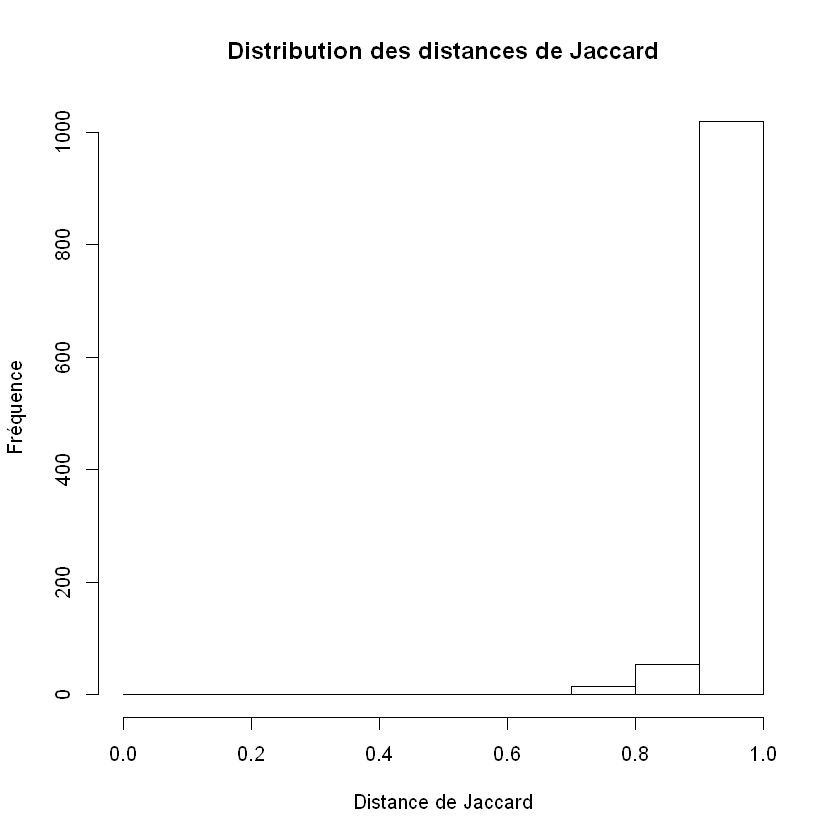

In [20]:
# On valide que l'article est à une distance nulle de lui-même
paste("Distance de 422908 avec lui-même: ")
jacc_422908['422908','422908']

# Distribution des distance de Jaccard avec 422908
hist(as.matrix(jacc_422908),
    main="Distribution des distances de Jaccard",
    xlab="Distance de Jaccard",
    ylab="Fréquence")


# Transpose pour faciliter la lecture visuelle
t_jacc_422908 <- t(jacc_422908)
colnames(t_jacc_422908) <- 'Distance de Jaccard avec 422908'

# Extraction des index les plus faible
index_min_jacc <- min.nindex(t_jacc_422908,11)

# Extraction des numéros d'articles avec la distance la plus faible
articles_min_jacc <- articles[index_min_jacc]
paste("Articles les plus près selon la distance de Jaccard")
(articles_min_jacc)

# Valeurs des distances de ces articles les plus proches
paste("Valeur des distances de Jaccard des articles les plus près")
jacc_422908[index_min_jacc]

df_voisin1_out

Encore une fois, nous avons que *422908* est le plus près de lui-même (analogue au fait que *422908* est l'article le plus similaire en cosinus avec lui-même).

Cette troisième méthode de recommendation vient grandement confirmer nos recommendations émises aux questions 1 et 2 du tp. En effet, nous retrouvons encore une fois les articles 
- *96767*
    - arc entrant avec la seconde plus grand valeur de PageRank
- *70445*
    - voisins sortant d'ordre 2, 4e suggestions en terme de valeur de PageRank lorsque l'on étend l'analyse aux voisins d'ordre 2. Il existe 4 chemins différents d'ordre 2 de *422908* vers *70445*
- *155792*
    - 4e voisin le plus populaire (valeur de PageRank) parmis les références de *422908*
- *53632*
    - 6e article le plus similaire en cosinus de *422908*


Nous avons fait cette exploration supplémentaire avec la distance de Jaccard simplement pour mettre en application une métrique/distance différente. Il en existe une panoplie et il est important de ne pas toujours se limiter à la similitude en cosinus. 

### Question 3: Utilisez une validation croisée pour évaluez la performance de l'approche par similitude en cosinus.

La question 3 nous demande de valider notre approche utilisée à la question précédente à l'aide d'une méthode de validation croisée. Nous avons appliqué telle quelle la méthodologie de l'article suggéré (*On the recommending of citations for research papers.*):

1. Nous sélectionnons tous les articles ayant un minimum de **X** références sortantes (**X** est le premier hyperparamètre).
2. Nous séparons les articles sélectionnés en 10 blocs.
3. Pour chaque bloc (un après l'autre, soit des *folds*), nous retirons une référence au hasard par article.
4. Nous replaçons les articles (maintenant avec une référence en moins) du bloc dans la matrice d'adjacence.
5. Nous calculons la similitude en cosinus des articles du bloc avec tous les autres articles de la matrice d'ajdacence modifiée.
6. Nous regardons si pour chaque article, la référence enlevée fait partie de ses **Y** similitude en cosinus les plus élevées (**Y** est le deuxième hyperparamètre). 
7. Si oui, alors nous avons réussi à retrouver la références qui a été enlevé. Nous comptabilisons un essaie positif pour cet article de ce bloc de validation.
8. Pour chaque combinaison d'hyperparamtètres **X** et **Y** nous obtenons donc 10 valeurs (une par bloc) de précision. Pour chaque combinaison, nous calculons la moyenne et l'écart-type de la distribution des 10 précisions obtenues.


Au terme de ce processus, nous obtenons une valeur (moyenne) de la précision pour une combinaison de **X** et **Y**. Il est évident que pour un même **X**, plus **Y** est élevé, plus la précision devrait être élevé (nous sélectionnons les même articles, mais nous permettons de regarder plus d'articles lors de la comparaison avec les top similitude en cosinus). La preuve en est que si **Y** vaut 1090 (le nombre d'articles), alors la précision sera toujours de 100%. Il est moins évident d'émettre une hypothèse sur le comportement de la précision lorsque **Y** est fixe et que **X** augmente. Il est intuitif de déduire que puisque les articles sélectionnés possède plus de références sortantes, alors en enlever une devrait très peu modifier leur similitude en cosinus avec les autres articles. Cependant, cela suppose que la similitude en cosinus est effectivement une méthode efficace pour trouver des articles similaires (ce que nous essayons de valider...). 

En plus d'effectuer le *leave one out* de références, nous avons décider de comparer la précision moyenne obtenu pour chaque combinaison d'hyperparamètre avec deux *baselines*. Effectivement, simplement en effectuant le *leave on out*, nous obtenons une précision très difficile à mettre en perspective. Disons que nous obtenons une précision de 27%, est-ce un bon résultat? En utilisant des recommendations naïves (les *baselines*) obtienderions nous une meilleure précision? C'est ce que nous voulions vérifier. Par exemple, si nous pensons à un modèle pour prédire le résultats d'un jeu de *pile ou face*, une précision de 27% serait très mauvaise puisqu'au hasard nous pouvons avoir une précision de 50% (e.g. toujours prédire *face*). Similairement, nous pourrions dire qu'une *baseline* ''zéro'' (donc très élémentaire) pourrait être de suggérer au hasard un article parmi les 1090. Nous aurions donc une précision de $\frac{1}{1090}$%, soit 0.09%. 

Voici les deux *baselines* avec lesquelles nous comparons nos résultats issues de la validation croisées:

1. Pour une expérience d'hyperparamètre **Y** donné, toujours suggérés les **Y** articles ayant les valeurs de PageRank les plus élevés.
    - Il n'y a donc aucune personnalisation face à l'article qui s'est vu retirer une référence. Nous ne faisons que suggérer les **Y** articles les plus populaires de la base de données.

2. Pour une expérience d'hyperparamètre **Y** donnée, toujours suggérés les **Y** articles ayant le plus de référants entrants.
    - Encore une fois, il n'y a pas de personnalisation face à l'artcile qui s'est vu retirer une référence. Le raisonnement derrière cette *baseline* est que les articles ayant beaucoup de référant ont des chances élevées d'être la référence d'un aut article.
    
    
Voici les valeurs d'hyperparamètres que nous avons choisies pour nos expériences:

**X**={4,9,10,14} et **Y**={5,20,50,100,200}. Nous avons déterminé ces valeurs en observant les distributions du nombre de références sortantes et du nombre de similitudes en cosinus étant non-nulle et pas un *NaN*. 

Effectivement, nous avons 351 similitudes en cosinus *NaN* (division par des articles de norme zéro, puisqu'ils ne possèdent aucune références) et nous avons, pour l'article *422908*, 467 similitudes en cosinus nulles (numérateur nulle, car aucune références en commun avec aucun autre article). Nous assumons que tous les articles devraient avoir envirion autant de similude nulle (sinon voir plus) que l'article *422908*. Ainsi, il reste environ 272 articles en moyenne dont nous avons une valeur utilisable de similitude en cosinus. Voilà pourquoi nous n'avons pas augmente **Y** au-dessus de 200. 

Pour déterminer **X**, nous avons regarder la distribution du nombre de références sortantes d'un article:



In [47]:
sum(ref_out>1)
sum(ref_out>4)
sum(ref_out>9)
sum(ref_out>10)
sum(ref_out>14)
sum(ref_out>15)
sum(ref_out>20)
sum(ref_out>30)

[1] 542

[1] 229

[1] 47

[1] 32

[1] 13

[1] 10

[1] 6

[1] 2

Initiallement, nous aurions aimer inclure **Y**=20 dans nos expériences, mais tel qu'il peut être constaté dans la cellule ci-dessus, seulement 6 articles respectent cette condition. Cela représente trop peu de données pour réellement être en mesure d'effectuer de la validation croisée et obtenir des résultats significatifs.

Explorons donc les résultats de nos expériences ainsi que la comparaison avec les deux *baselines*.

Dans l'implémentation, nous avons nommé **X**: *nbx_ref* et **Y**: *N*.

In [16]:
#On extrait les articles ayant plus de nbx_ref de ref_out

## nbx_ref : Nombre de reference d'un article pour qu'il soient jugé "interessant"
## N du top N

Nlist <- cbind(5, 20, 50, 100, 200)
nbx_ref_list <- cbind(4, 9, 14)

In [ ]:
### Validation croisé Initialisation :
Kr <- 10 # pour 10-validation croisée
#Execution du programme avec différents hyper param
for (N_index in 1:length(Nlist)) { 
#for (N_index in 1:1) {
    N <- Nlist[N_index]
    
    pr_topN <- articles[max.nindex(pr, N)]
    ref_in_topN <- articles[max.nindex(ref_in, N)]
    
    for (nbx_ref_index in 1:length(nbx_ref_list)){
    #for (nbx_ref_index in 1:1){
        nbx_ref <- nbx_ref_list[nbx_ref_index]
        lot_reference_index_article <- m[ref_out > nbx_ref_list[nbx_ref_index],]
        n <- length(m[ref_out > nbx_ref])
        
        #head(lot_reference_index_article)
        #print(dim(lot_reference_index_article))
        #paste("Nombre d'article référencant plus de 4 articles")
        
        #################################################################################################
        ### Validation croisé Initialisation :
        taille_echantillon <- n %/% Kr
        set.seed(5) ### ?Pour l'aléatoire
        alea <- runif(n) # Generates n uniform random numbers between 0 and 1.
        rang <- rank(alea) # Donne le rang des elements d'alea

        # Associer à chaque individu un numéro de bloc
        # Rang compris entre 1 et n donc bloc compris entre 1 et K, 
        # Donne à chaque individu, l'indice de l'intervalle auquel il appartient.
        bloc <- (rang-1) %/% taille_echantillon + 1
        bloc <- as.factor(bloc)
        
        ###Stock les résultats des 10 folds de la validation
        vect_prec <- numeric(0)
        vect_prec_ref_in <- numeric(0)
        vect_prec_pr <- numeric(0)
        
        #################################################################################################
        
        ### Exécution de la validation croisée
        for (j in 1:Kr){
            
            article_to_remove_ref <- lot_reference_index_article[bloc == j,]
            article_to_remove_ref_out <- rowSums(article_to_remove_ref)
            set.seed(5)
            m_modif <- m
            rowNames <- row.names(article_to_remove_ref)
            remove_ref_names <- numeric(0)
            vect_ref_in_topN <- numeric(0)
            vect_ref_in_pr_topN <- numeric(0)
            vect_ref_in_refin_topN <- numeric(0)

            #################################################################################################
            #On retire une reference à chaque article appartenant au 10% des articles bien défini
            for (i in 1:dim(article_to_remove_ref)[1]){

                rd_int <- sample(1:article_to_remove_ref_out[i], 1)

                m_modif[rowNames[i],][which(article_to_remove_ref[i,]==1)][rd_int] <- 0
                remove_ref_name <- colnames(m_modif[rowNames[i],][which(article_to_remove_ref[i,]==1)][rd_int])
                remove_ref_name <- str_remove(remove_ref_name, "[X]")
                remove_ref_names <- rbind(remove_ref_names, remove_ref_name)
                
                ### Baseline : "Est ce que la référence enlevé est dans le TopN pr et ref_in?":
                vect_ref_in_pr_topN <- cbind(vect_ref_in_pr_topN, remove_ref_name %in% pr_topN)
                vect_ref_in_refin_topN <- cbind(vect_ref_in_refin_topN, remove_ref_name %in% ref_in_topN)

            }
            #################################################################################################
            
            # On calcul similarité du cosinus sur toute la matrice (avec les références enlevées m_modif):
            # On calcul la similarité en cosinus de chaque article avec chacun des autres
            cos_simil <- as.data.frame(distance(m_modif, method = "cosine"))
            
            # On renomme les lignes et colonnes pour faciliter l'implementation
            colnames(cos_simil) <- articles
            rownames(cos_simil) <- articles

            # On extrait la similitude de l'article avec chacun des autres articles, pour les articles auquels on a enlevé une référence
            cos_simil_rowNames <- cos_simil[rowNames,]

            for (r in 1:nrow(cos_simil_rowNames)){

                #Similitude de la reference enleve
                print("Valeur du cosinus de la référence enlevé : ")
                print(cos_simil_rowNames[r, remove_ref_names[r]])

                ordered_index <- order(t(cos_simil_rowNames[r,]), decreasing=TRUE, na.last = TRUE)
                ordered_list <- sort(t(cos_simil_rowNames[r,]), decreasing=TRUE, na.last = TRUE)

                print("Rang de la référence enlevée : ")
                #Rang de la reference enleve
                rank_removed_ref <- which(ordered_list == cos_simil_rowNames[r, remove_ref_names[r]])[1]
                print(which(ordered_list == cos_simil_rowNames[r, remove_ref_names[r]])[1])

                # Remplissage du vecteur pour calculé la "précision" du fold
                if (!is.na(rank_removed_ref) && rank_removed_ref <= N) {
                    vect_ref_in_topN <- cbind(vect_ref_in_topN, 1)
                } else {
                    vect_ref_in_topN <- cbind(vect_ref_in_topN, 0)
                }
            }
            prec <- sum(vect_ref_in_topN)/length(vect_ref_in_topN)
            prec_pr <- sum(vect_ref_in_pr_topN)/length(vect_ref_in_pr_topN)
            prec_ref_in <- sum(vect_ref_in_refin_topN)/length(vect_ref_in_refin_topN)

            vect_prec <- rbind(vect_prec, prec)
            vect_prec_ref_in <- rbind(vect_prec_ref_in, prec_ref_in)
            vect_prec_pr <- rbind(vect_prec_pr, prec_pr)
        }
        ### Sauvegarde des résultats selon les hyper-paramètre
        ##set the col name
        colnames(vect_prec) <- "Précision de la prévision"
        colnames(vect_prec_pr) <- "Précision de la baseline PageRank"
        colnames(vect_prec_ref_in) <- "Précision de la baseline RefIn"
        ## set the row name?
        
        
        write.table(vect_prec,file=paste( nbx_ref , N , "prec.txt", sep="_"))
        write.table(vect_prec_pr,file=paste( nbx_ref , N , "precPageRank.txt", sep="_"), append=TRUE)
        write.table(vect_prec_ref_in,file=paste( nbx_ref , N , "precRefIn.txt", sep="_"), append=TRUE)
        print("##################################END SAVE############################################")
        # Fin de la validation croisée
        #################################################################################################
    }
}

Puisque nous avons performé plusieurs expériences avec différentes combinaisons d'hyperparamètres, l'exécution de la validation croisée est relativement longue. Voilà pourquoi nous avons implémenté une méthode pour charger les résultats.

In [73]:
# Initialisation du dictionnaire des expériences
exp <- hash()

#### Lire les fichiers sauvegardé
for (N_index in 1:length(Nlist)) {
    N <- Nlist[N_index]
    for (nbx_ref_index in 1:length(nbx_ref_list)){
        nbx_ref <- nbx_ref_list[nbx_ref_index]

        pathname_prec <- paste( nbx_ref , N , "prec.txt", sep="_")
        pathname_prec_pr <- paste( nbx_ref , N , "precPageRank.txt", sep="_")
        pathname_prec_ref_in <- paste( nbx_ref , N , "precRefIn.txt", sep="_")
        
        
        Rprec <- as.matrix(read.table(pathname_prec, nrows = 10, row.names=NULL)[,2])
        Rprec_pr <- as.matrix(read.table(pathname_prec_pr, row.names=NULL)[,2])
        Rprec_refIn <- as.matrix(read.table(pathname_prec_ref_in, row.names=NULL)[,2])
        
        df_ite <- data.frame(Rprec, Rprec_pr, Rprec_refIn)
        df_ite <- rbind(df_ite,colMeans(df_ite))
        colnames(df_ite) <- c("Experience","PR","Ref_In")
        row.names(df_ite) <- c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "Average")
        
        experience <- paste(nbx_ref, N, sep="_")
        exp[experience]<-df_ite

        
        
        }
    }

Afin de facilement pouvoir accéder à tous nos résultats (des 15 expériences), nous avons créer un dictionnaire *exp* dont chaque *key* est le nom d'un expérience et chaque *value* est le *dataframe* correspondant. Cest *dataframes* contiennent la précision de l'expérience (similitude en cosinus), la valeur de la *baseline* PageRank et la valeur de la *baseline* selon les références entrantes.

In [84]:
# Exemple de la structure des données
cat("Résultats pour nbx_ref=4 et Top 5 recommendations:\n\n")
print(exp[["4_5"]])


Résultats pour nbx_ref=4 et Top 5 recommendations:

        Experience         PR     Ref_In
1       0.09090909 0.22727273 0.22727273
2       0.22727273 0.04545455 0.13636364
3       0.09090909 0.13636364 0.09090909
4       0.18181818 0.18181818 0.18181818
5       0.09090909 0.13636364 0.18181818
6       0.04545455 0.27272727 0.22727273
7       0.27272727 0.36363636 0.27272727
8       0.09090909 0.22727273 0.22727273
9       0.22727273 0.18181818 0.13636364
10      0.27272727 0.13636364 0.09090909
Average 0.15909091 0.19090909 0.17727273


Nous pouvons voir une très grande variation de la précision à travers les *folds*. Ceci peut s'expliquer par le fait que peu d'observations font partie de chaque *fold*. Notre base de données est assez petite (1090 articles) et en plus, la piètre qualité des données réduit grandement le nombre d'observations que nous pouvons mettre dans notre échantillon (comme expliqué plus haut, l'expérience ayant le plus d'articles en possède seulement environ 270). 

Déterminons parmis nos 15 expériences, combien ont réussi à obtenir une meilleure précisions que les *baselines*.

In [129]:
nbx_ref=c(4,9,14)
N=c(5,20,50,100,200)
compteur=0
for (i in nbx_ref){
    for (j in N){
        experience <- paste(i,j,sep="_")
        avg_exp <- exp[[experience]]['Average', 'Experience']
        avg_pr <- exp[[experience]]['Average', 'PR']
        avg_ref_in <- exp[[experience]]['Average', 'Ref_In']
        
        if (avg_exp>=avg_pr){
            if(avg_exp>=avg_ref_in){
            compteur=compteur+1
            print(paste("Pour l'expérience nbx_ref=", i," et N=",j, " la similitude en cosinus donne une meilleure précision que les baselines"))
            print(exp[[experience]]['Average',])
            cat('\n')
        }
        }
}}

print(paste("Pour ",compteur," de nos 15 expériences, l'approche par similitude en cosinus a obtenu une meilleure précision que les deux baselines"))

[1] "Pour l'expérience nbx_ref= 4  et N= 20  la similitude en cosinus donne une meilleure précision que les baselines"
        Experience        PR Ref_In
Average  0.3636364 0.2727273    0.3

[1] "Pour l'expérience nbx_ref= 4  et N= 50  la similitude en cosinus donne une meilleure précision que les baselines"
        Experience        PR Ref_In
Average  0.4863636 0.3681818    0.4

[1] "Pour l'expérience nbx_ref= 4  et N= 100  la similitude en cosinus donne une meilleure précision que les baselines"
        Experience        PR    Ref_In
Average  0.6045455 0.4909091 0.5636364

[1] "Pour l'expérience nbx_ref= 9  et N= 5  la similitude en cosinus donne une meilleure précision que les baselines"
        Experience PR Ref_In
Average       0.15  0   0.05

[1] "Pour l'expérience nbx_ref= 9  et N= 20  la similitude en cosinus donne une meilleure précision que les baselines"
        Experience  PR Ref_In
Average      0.325 0.1   0.15

[1] "Pour l'expérience nbx_ref= 9  et N= 50  la similitude e

Pour 12 de nos 15 expériences, l'approche par similitude en cosinus était meilleure que de simplement suggérer les articles les plus populaires ou les articles ayant le plus de références entrantes.

Les 3 expériences pour lesquelles au moins une *baseline* était plus performante que notre approche sont les expériences (4,5), (4,200) et (14,200) ou le premier argument représente *nbx_ref* et le second représente *N*.

Les échecs ou les réussite pour les expériences où *N=200* sont assez vide de sens. En effet, nous suggérons presque l'entièreté de tous les autres articles, ainsi, peut-importe la méthode pour déterminer l'ordonnacement, il est virtuellement impossible d'avoir une mauvaise précision. 

Il reste donc seulement l'expérience (4,5) pour laquelle les *baselines* ont eu une meilleure précision que l'approche par similitude en cosinus. C'est effectivement l'expérience pour laquelle les observations sont mal représentées (seulement 3 références restantes après le retrait d'une référence) et en plus, seulement un top 5 est suggéré. 

Cela nous indique donc que l'approche par similitude en cosinus semble mieux performer que des approches naïves (telles les deux *baselines*), mais uniquemment lorsque nous possédons assez d'information (donc relativement beaucoup de références) sur l'article et lorsque nous donnons une certaine marge d'erreur acceptable (en allant chercher un top N d'articles d'au moins 20). 

L'approche par similitude en cosinus est particulièrement plus performante que les deux *baselines* lorsque la qualité (donc le nombre de références disponibles) des articles dans les *folds* augmente. Cela démontre bien que notre approche construit sur les connaissances disponibles, à comparer au approche naïves qui suggèrent toujours les même articles (soient les plus populaires ou ceux ayant le plus de référant). 

Visualisons les résultats des 5 expériences pour lesquelles *nbx_ref*=9. Ces expériences démontrent bien le comportement général de notre approche face aux *baselines*. 

In [154]:
exp_9 <- rep(0, 5)
PR_9 <-rep(0, 5)
ref_in_9 <- rep(0, 5)

for (i in seq(5)){
    number <- paste("9_",N[i],sep='')
    df <- exp[[number]]
    df_avg <- df['Average',]
    exp_9[i] <- df_avg[,1]
    PR_9[i] <- df_avg[,2]
    ref_in_9[i] <- df_avg[,3]
    print(df_avg)
}


        Experience PR Ref_In
Average       0.15  0   0.05
        Experience  PR Ref_In
Average      0.325 0.1   0.15
        Experience  PR Ref_In
Average      0.425 0.2    0.3
        Experience    PR Ref_In
Average        0.6 0.325   0.45
        Experience    PR Ref_In
Average       0.65 0.475  0.525


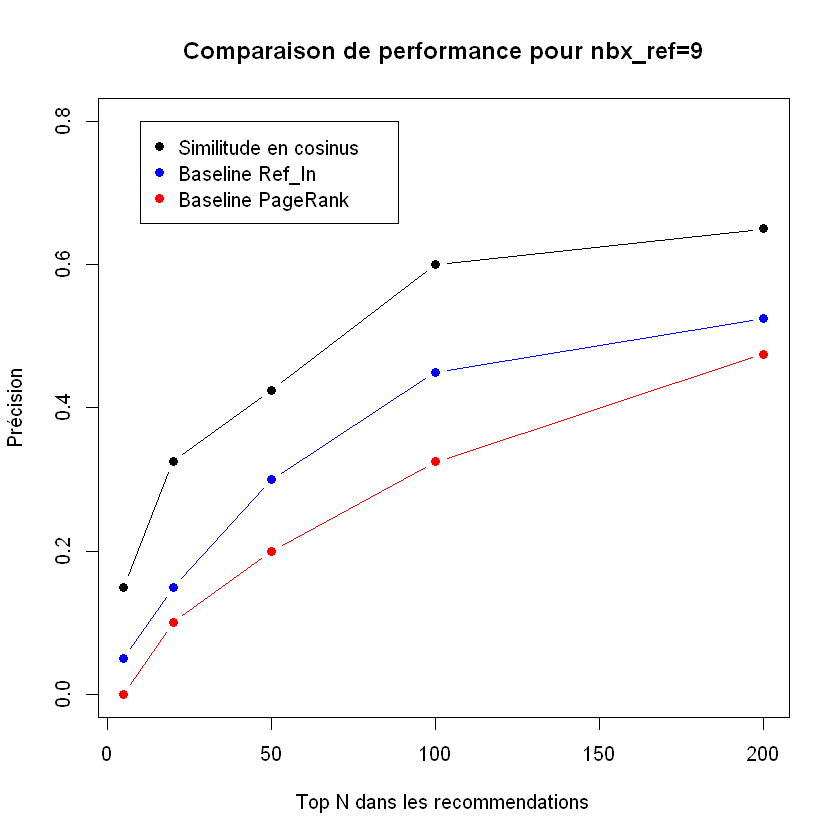

In [212]:
plot(N, exp_9,
    main="Comparaison de performance pour nbx_ref=9",
    xlab="Top N dans les recommendations",
    ylab="Précision",
    pch=19,
    type='b',
    col='black',
    ylim=c(0,0.8))


points(N, ref_in_9,
      pch=19,
      col='blue',
      type='b')

points(N, PR_9,
      pch=19,
      col='red',
      type='b')

legend(10, 0.8, legend=c("Similitude en cosinus", "Baseline Ref_In" ,"Baseline PageRank"),
       col=c("black", "blue","red"),pch=c(19,19,19))

Le graphique ci-dessus présente les résultats de chaque expérience moyenné sur les 10 *folds*.

Les tendances trouvées pour *nbx_ref*=9 sont similaires à celles établies pour *nbx_ref*=4 et *nbx_ref*=14. Par soucis de concision, seulement les résultats pour *nbx_ref*=9 sont présentées. Il aurait été redondant de présenter les résultats de chacunes des expériences.

On observe que la similitude en cosinus est plus performante que les deux *baselines* sélectionnées pour retrouver un voisin retiré. Donc, relativement aux *baselines*, l'approche par similitude en cosinus est acceptable. Cependant, de manière aboslue, la performance n'est pas excellente. En effet, lorsque nous regardons les expériences dont le Top N est respectable (soient 5 et 20), l'approche par similtiude ne réussit qu'à avoir une précision de 33%. En moyenne, une fois sur 3 nous réussissons donc à retrouver la référence manquante. Ceci est donc moindrement performant, dans l'absolue, comme approche.

Une approche plus performante aurait possiblement été de trouver l'article le plus similaires à toutes les références restantes de l'article. Nous aurions donc été plus près d'une approche item-item que d'un simple calcul en similitude. 

Définitivement, l'approche par similitude ainsi que les deux *baselines* sont bien meilleures que de recommender un article au hasard parmis les 1090 de la base de données.